In [1]:
%load_ext autoreload
import numpy as np
import xarray as xr
import pandas as pd

# Signal processing 
import scipy.signal as ssignal

# dashboard
import panel as pn
from panel.interact import fixed
import param

# plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
import sciplotlib.polish as splpolish 
import sciplotlib.style as splstyle

import os 
import glob
import pickle as pkl
import h5py
# For downloading df to csv 
from io import StringIO

# analysis 
import detect_spikes as dspike
import process_spikes as pspikes

# Network
import networkx as nx

# Bokeh 
import bokeh as bk
from bokeh.io import output_file, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool, StaticLayoutProvider)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx


# Datashader and holoviz for large plots 
from holoviews.operation.datashader import datashade
import holoviews as hv
import datashader as ds

pn.extension()

/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: 'numba.targets.imputils', pleas

In [5]:
%autoreload
class SpikeData(param.Parameterized):
    

    load_file_path = param.FileSelector()
    raw_traces = param.Array()
    
    # Dataframe for datashader
    raw_trace_df = None
    
    num_channels = param.Integer(default=2)
    channel_to_plot = param.Number(default=1)
    spike_detection_method = param.ObjectSelector(default='manuel', objects=['manuel', 'cwt'])
    spike_matrix = None
    grid_matrix = None
    recording_duration = None
    # down_sampled_spike_matrix = param.Array()
    down_sample_factor = 2500
    down_sampled_spike_matrix = None
    # spike_detection_multiplier = param.Number(5, bounds=(0, 10))
    spike_detection_multiplier = param.Number(5)
    fs = param.Number(25000)
    spike_detection_progress = pn.widgets.Progress(name='Progress', value=0, width=200)
    spike_alignment_progress = pn.widgets.Progress(name='Progress', value=0, width=200)
    get_spike_triggered = False
    alignment_range = param.Array(np.array([0.05, 0.05]))
    spike_alignment_matrix = None
    spike_matrix_cmap =  param.ObjectSelector(default='viridis', objects=['viridis', 'seismic', 'Greys',
                                                                              'plasma', 'inferno'])
    
    spike_matrix_colorscale = param.ObjectSelector(default='linear', objects=['linear', 'log10'])
    small_log_offset = 0.1

    electrode_correlation_matrix = None
    
    channle_trace_plotting_backend = param.ObjectSelector(default='matplotlib', objects=['matplotlib', 'bokeh'])
    
    correlation_histogram_num_bin = param.Number(10)
    node_metric_histogram_num_bin = param.Number(10)
    histogram_metric_to_plot = param.ListSelector(default=['correlation'], objects=['correlation'])
    node_metric_to_plot = param.ListSelector(default=['node_degree'], objects=['node_degree', 'firing_rate'])
    
    # Parameters for making the network plot
    G = None   # networkX graph object
    network_plotting_backend = param.ObjectSelector(default='bokeh', objects=['matplotlib', 'bokeh'])
    network_edge_correlation_threshold = param.Number(0.5, bounds=(0, 1), step=0.02)
    x_pos = np.arange(0, 8)
    y_pos = np.arange(0, 8)
    xx, yy = np.meshgrid(x_pos, y_pos)
    coord = np.array([xx.flatten(), yy.flatten()]).T
    four_corner_removed_coord = np.concatenate([coord[1:7, :], coord[8:56], coord[57:64]])
    coord_dict = dict()
    
    # Network properties 
    node_degrees = None
    node_firing_rate = None
    
    # Parameters for saving spike data 
    spike_save_format = param.ObjectSelector(default='xarray', objects=['xarray', 'mat', 'df'])
    
    # Multiple spike files
    spike_collection = None

    @param.depends('load_file_path', watch=True)
    def load_raw_data(self):
        
        file_path = self.load_file_path

        if type(file_path) is list:
            if len(file_path) == 1:
                file_path = file_path[0]
            elif (len(file_path) >= 2) & np.all(['spike' in file_name for file_name in file_path]):
                # load multiple spike files 
                self.spike_collection = dict()
                for file_p in file_path:
                    if '.pkl' in file_p:
                        with open(file_p, 'rb') as handle:
                            spike_df_dict = pkl.load(handle)
                        
                        # obtain file name 
                        file_name = os.path.basename(file_p)
                        file_name = file_name.split('.')[0]
                        
                        spike_data = dict()
                        spike_df = spike_df_dict['df']  
                        spike_data['channel_id'] = spike_df_dict['metadata']['channel_id']
                        spike_data['num_frames'] = spike_df_dict['metadata']['num_frames']
                        spike_data['fs'] = spike_df_dict['metadata']['fs']
                        spike_data['recording_duration'] = spike_data['num_frames'] / spike_data['fs']
                        spike_data['down_sampled_spike_matrix'], spike_data['time_coords'] = \
                        pspikes.bin_spikes_sparse(spike_df, 
                          spike_time_column='spikeTime',
                          cluster_column='electrode',
                          t_start=0, t_end=spike_data['recording_duration'], 
                          original_sampling_rate=spike_data['fs'],
                          down_sample_factor=self.down_sample_factor,                                                                   
                          sampling_rate=self.down_sample_factor, output_type='dense',
                          cluster_idx=spike_data['channel_id'])
                        
                        self.spike_collection[file_name] = spike_data
                
            else:
                return None

        if file_path is not None:
            if 'spike' in file_path:
                if '.npy' in file_path:
                    self.spike_matrix = np.load(file_path)
                elif '.nc' in file_path:
                    self.loaded_spike_file = True
                    spike_ds = xr.open_dataset(file_path)
                    # self.spike_ds = spike_ds
                    # spike_matrix_values = self.spike_ds.Spikes.values
                    self.spike_matrix = spike_ds.Spikes.values
                    self.num_channels = len(spike_ds['Channel'])
                    self.fs = 25000
                    self.num_frames = len(spike_ds['Time'])
                    self.channel_id = spike_ds['Channel'].values
                    self.recording_duration = self.num_frames / self.fs
                elif '.pkl' in file_path:
                    self.loaded_spike_file = True 
                    with open(file_path, 'rb') as handle:
                        spike_df_dict = pkl.load(handle)
                        
                    spike_df = spike_df_dict['df']    
                    self.channel_id = spike_df_dict['metadata']['channel_id']
                    self.num_frames = spike_df_dict['metadata']['num_frames']
                    self.fs = spike_df_dict['metadata']['fs']
                    self.recording_duration = self.num_frames / self.fs
                    
                    self.down_sampled_spike_matrix, time_coords = pspikes.bin_spikes_sparse(spike_df, 
                      spike_time_column='spikeTime',
                      cluster_column='electrode',
                      t_start=0, t_end=self.recording_duration, 
                      original_sampling_rate=self.fs,
                      down_sample_factor=self.down_sample_factor,                                                                   
                      sampling_rate=self.down_sample_factor, output_type='dense',
                      cluster_idx=self.channel_id)
                    
                    self.num_channels = spike_df_dict['metadata']['num_channels']

                    
                    
            elif '.mat' in file_path:
                # load matlab data
                f = h5py.File(file_path)
                data = {}
                for k, v in f.items():
                    data[k] = np.array(v)
                
                
                self.raw_traces = data['dat']
                self.num_channels = np.shape(self.raw_traces)[0]
                self.num_frames = np.shape(self.raw_traces)[1]
                self.fs = data['fs'][0][0]
                self.channel_id = data['channels'][0]
                self.recording_duration = self.num_frames / self.fs
                
                # Also include a df version to allow for datashader poltting 
                raw_trace_df = pd.DataFrame(self.raw_traces.T)
                raw_trace_df['Time'] = np.arange(self.num_frames) / self.fs
                self.raw_trace_df = raw_trace_df

            else:
                print('File type not supported.')
                data = None 
        else:
            data = None

    
    # @param.depends('raw_traces', 'channel_to_plot')
    @param.depends('raw_traces', 'raw_trace_df', 'channel_to_plot')
    def plot_channel_trace(self, fig=None, ax=None, backend='bokeh'):
        
        # self.channel_trace_triggered = True

        if self.raw_traces is not None:
            if backend == 'matplotlib':
                with plt.style.context(splstyle.get_style('nature-reviews')):
                    if (fig is None) and (ax is None):
                        fig, ax = plt.subplots()
                        fig.set_size_inches(8, 3)

                    ax.set_title('Channel raw trace')
                    if self.raw_traces is not None and self.channel_to_plot is not None:
                        ax.plot(self.raw_traces[self.channel_to_plot, :])

                    plt.close(fig)

            elif backend == 'bokeh':
                if self.raw_trace_df is not None:
                    print('TODO: make bokeh time series plot')
                    # cols = [self.channel_to_plot]
                    opts = hv.opts.RGB(width=600, height=300)
                    # ndoverlay = hv.NdOverlay({c:hv.Curve((self.raw_trace_df['Time'], self.raw_trace_df[c]), 
                    #                                       kdims=['Time'], vdims=['Value']) for c in cols})
                    # ds_dynamic_map = datashade(ndoverlay, normalization='linear', aggregator=ds.count()).opts(opts)
                    # fig = ds_dynamic_map
                    # fig = pn.panel(ds_dynamic_map)
                    # fig = pn.Pane(ds_dynamic_map)
                    # fig = datashade(ndoverlay, normalization='linear', aggregator=ds.count()).opts(opts)
                    
                    # opts = hv.opts.RGB(width=800, height=300)
                    datashader_dynamicmap = datashade(hv.Curve((self.raw_trace_df['Time'], self.raw_trace_df[1])), 
                                     normalization='linear', aggregator=ds.any()).opts(opts)
                    fig = datashader_dynamicmap
                    # fig = Plot(plot_width=800, plot_height=300)
                    # fig.renderers.append(datashader_dynamicmap)
                

        return fig
    
    @param.depends('raw_traces', 'spike_detection_method', 'spike_detection_multiplier',
                   'fs', 'num_channels', watch=True)
    def get_spikes(self):
        
        # DONE: not sure why spike detection method trigger callback twice
        # This is because all 'wathced' param needs to be a Param object
        # See: https://stackoverflow.com/questions/58114082/why-is-my-plot-updated-by-panel-twice-when-i-change-a-button-setting-that-shou
        
        if (self.raw_traces is not None) and (self.fs is not None):
            self.get_spike_triggered = True

            spike_train_list = list()
            for channel_idx in np.arange(self.num_channels):
                spike_data = self.raw_traces[channel_idx, :]
                if self.spike_detection_method == 'manuel':
                    low_pass = 600
                    high_pass = 8000 
                    filter_order = 3

                    wn = np.array([low_pass, high_pass]) / (self.fs / 2)

                    b, a = ssignal.butter(filter_order, Wn=wn, btype='bandpass')

                    filtered_data = ssignal.filtfilt(b, a, spike_data)

                    # finding threshold and spikes
                    m = np.mean(filtered_data); 
                    s = np.std(filtered_data); 
                    threshold = m - self.spike_detection_multiplier * s; 
                    neg_threshold = m - 8 * s; # maximum threshold, a simple artefact removal method 
                    spike_train = (filtered_data < threshold).astype(int)


                    # Impose refractory period 
                    ref_period = 2.0 * 10 ** -3 * self.fs

                    spike_train_list.append(spike_train)
                
                self.spike_detection_progress.value = int((channel_idx + 1) / self.num_channels * 100)

            self.spike_matrix = np.stack(spike_train_list)
            # self.down_sampled_spike_matrix = self.down_sample_spike_matrix(
            #     self.spike_matrix, down_sample_factor=2500)
            # self.down_sampled_spike_matrix = param.Array()
    
    @param.depends('spike_matrix', watch=True)
    def down_samp(self):
        
        if self.spike_matrix is not None:
            down_sample_factor = self.down_sample_factor
            spike_matrix = self.spike_matrix

            num_channels = np.shape(spike_matrix)[0]
            original_num_samp = np.shape(spike_matrix)[1]
            new_num_samp = original_num_samp / down_sample_factor 
            reshaped_spike_matrix = np.reshape(spike_matrix, 
                                               (int(num_channels), int(new_num_samp), -1))
            # down_sampled_matrix = np.sum(reshaped_spike_matrix, axis=-1)

            self.down_sampled_spike_matrix = np.sum(reshaped_spike_matrix, axis=-1)
        
            
    # Save detected spikes
    save_spikes_button = param.Action(lambda x: x.param.trigger('save_spikes_button'), label='Save spikes')
    @param.depends('save_spikes_button', watch=True)
    def save_detected_spikes(self):
        if self.spike_matrix is not None:
            if self.spike_save_format == 'xarray':
                spike_ds = xr.Dataset({'Spikes': (['Channel', 'Time'], self.spike_matrix)},
                                     coords={'Channel': ('Channel', self.channel_id),
                                            'Time': ('Time', np.arange(self.num_frames) / self.fs)})
                raw_data_file_path_without_ext = self.load_file_path[0].split('.')[0]
                save_path = raw_data_file_path_without_ext + '_spikes.nc'
                spike_ds.to_netcdf(save_path)
            elif self.spike_save_format == 'df':
                spike_df = pspikes.spike_matrix_to_df(spike_matrix=self.spike_matrix, 
                                                      unit_id_list=self.channel_id, 
                                                      spike_time_column='spikeTime', cluster_column='electrode',
                                                      fs=self.fs)
                # save some metadata
                raw_data_file_path_without_ext = self.load_file_path[0].split('.')[0]
                spike_df_dict = {'metadata': {'Name': raw_data_file_path_without_ext, 
                                             'num_channels': self.num_channels,
                                             'num_frames': self.num_frames,
                                             'fs': self.fs,
                                             'channel_id': self.channel_id},
                                'df': spike_df}
                save_path = raw_data_file_path_without_ext + '_spikes.pkl'
                with open(save_path, 'wb') as handle:
                    pkl.dump(spike_df_dict, handle)

            
    @param.depends('spike_matrix', 'channel_to_plot', 'alignment_range', watch=True)
    def align_spikes(self):
        """
        Align spikes to get the average waveform
        """
        num_frame_before_spike = self.alignment_range[0] * self.fs
        num_frame_after_spike = self.alignment_range[1] * self.fs

        if (self.spike_matrix is not None) and (self.raw_traces is not None):
            spike_alignment_traces = list()
            channel_trace = self.raw_traces[self.channel_to_plot, :]
            channle_num_sample = len(channel_trace)
            spike_train = self.spike_matrix[self.channel_to_plot, :]
            spike_times = np.where(spike_train)[0]
            num_spikes = len(spike_times)

            for n_spike, spike_idx in enumerate(spike_times):
                pre_spike_frame = spike_idx - num_frame_before_spike
                post_spike_time = spike_idx + num_frame_after_spike
                if (pre_spike_frame > 0) & (post_spike_time < channle_num_sample):
                    spike_alignment_traces.append(channel_trace[int(pre_spike_frame):
                                                         int(post_spike_time)])
                self.spike_alignment_progress.value = int((n_spike + 1) / num_spikes * 100)
        
            self.spike_alignment_matrix = np.vstack(spike_alignment_traces)
        
    
    @param.depends('raw_traces', 'down_sampled_spike_matrix', 'spike_matrix_cmap', 'spike_matrix_colorscale')
    def plot_raster(self, cmap='viridis', 
                    cmap_scale='linear', backend='matplotlib',fig=None, ax=None):
    
    
        if backend == 'matplotlib':
            with plt.style.context(splstyle.get_style('nature-reviews')):
                if (fig is None) and (ax is None):
                    fig, ax = plt.subplots() 
                    fig.set_size_inches(8, 4)

                ax.set_title('Spike raster')
                make_plot = True
                
                if self.spike_matrix_colorscale == 'linear': 
                    norm = None
                else:
                    norm = mpl.colors.LogNorm()
                    # self.down_sampled_spike_matrix += self.small_log_offset
                    
                if self.down_sampled_spike_matrix is not None and make_plot:
                    dsamp_spike_matrix = self.down_sampled_spike_matrix
                    im = ax.imshow(dsamp_spike_matrix, aspect='auto', 
                                  cmap=self.spike_matrix_cmap, norm=norm)
                    cbar = fig.colorbar(im)
                    
                plt.close()

    
        return fig
    
    @param.depends('spike_alignment_matrix', watch=True)
    def plot_aligned_spikes(self, fig=None, ax=None):
        
        if (fig is None and ax is None):
            with plt.style.context(splstyle.get_style('nature-reviews')):
                fig, ax = plt.subplots()
                fig.set_size_inches(8, 4)
                ax.set_title('Aligned spikes (raw traces)')
        
        if self.spike_alignment_matrix is not None:
            with plt.style.context(splstyle.get_style('nature-reviews')):
                ax.plot(self.spike_alignment_matrix.T, color='black', alpha=0.2)
            
                plt.close()
        
        return fig  
    
    
    # Compute average spike 
    # This is ported from: https://github.com/Timothysit/mecp2/blob/master/Matlab_Analysis/heatMap/makeHeatMap.m
    @param.depends('down_sampled_spike_matrix', watch=True)
    def make_grid_matrix(self):
        
        if self.spike_collection is not None:
            
            for data_name, data_info in self.spike_collection.items():
                
                dsamp_spike_matrix = data_info['down_sampled_spike_matrix']
                data_vec = np.sum(dsamp_spike_matrix, axis=1)

                num_x_channel=8
                num_y_channel=8
                grounded_electrode=[5]

                temp_grid_matrix = np.zeros((num_x_channel, num_y_channel))


                # remove the four corners 
                temp_grid_matrix[0, 0] = np.nan
                temp_grid_matrix[0, 7] = np.nan
                temp_grid_matrix[7, 0] = np.nan 
                temp_grid_matrix[7, 7] = np.nan

                num_channel = len(data_vec)

                if num_channel == 60:

                    temp_grid_matrix.flat[1:6] = data_vec[0:5]
                    temp_grid_matrix.flat[8:55] = data_vec[6:53]
                    temp_grid_matrix.flat[57: 62] = data_vec[54:59]

                
                self.spike_collection[data_name]['grid_matrix'] = temp_grid_matrix
                
        
        if self.down_sampled_spike_matrix is not None:
            dsamp_spike_matrix = self.down_sampled_spike_matrix
            data_vec = np.sum(dsamp_spike_matrix, axis=1)

            num_x_channel=8
            num_y_channel=8
            grounded_electrode=[5]

            temp_grid_matrix = np.zeros((num_x_channel, num_y_channel))


            # remove the four corners 
            temp_grid_matrix[0, 0] = np.nan
            temp_grid_matrix[0, 7] = np.nan
            temp_grid_matrix[7, 0] = np.nan 
            temp_grid_matrix[7, 7] = np.nan

            num_channel = len(data_vec)

            if num_channel == 60:

                temp_grid_matrix.flat[1:6] = data_vec[0:5]
                temp_grid_matrix.flat[8:55] = data_vec[6:53]
                temp_grid_matrix.flat[57: 62] = data_vec[54:59]


            self.grid_matrix = temp_grid_matrix
            
            # also compute firing rate of each node 
            if self.recording_duration is not None:
                self.node_firing_rate = np.sum(dsamp_spike_matrix, axis=1) / self.recording_duration
    
    
    @param.depends('grid_matrix', watch=True)
    def plot_grid_matrix(self):
        
        if self.spike_collection is not None:
            
            with plt.style.context(splstyle.get_style('nature-reviews')):
                fig, ax = plt.subplots(1, len(self.spike_collection))
                fig.set_size_inches(6, 4)
                for n_data, (data_name, data_dict) in enumerate(self.spike_collection.items()):
                    im = ax[n_data].imshow(data_dict['grid_matrix'])
                    ax[n_data].set_title(data_name, size=11)
                    fig.suptitle('Firing rate')
                
            plt.close(fig)
                
            return fig
        
        elif self.grid_matrix is not None:
            with plt.style.context(splstyle.get_style('nature-reviews')):
                fig, ax = plt.subplots()
                fig.set_size_inches(4, 4)
                im = ax.imshow(self.grid_matrix)
                cbar = fig.colorbar(im)
                ax.set_title('Firing rate')
            
            plt.close(fig)

            return fig


    # Compute correlation matrix 
    @param.depends('down_sampled_spike_matrix', watch=True)
    def compute_correlation_matrix(self):
        if self.down_sampled_spike_matrix is not None:
            dsamp_spike_matrix = self.down_sampled_spike_matrix
            down_sampled_spike_df = pd.DataFrame(dsamp_spike_matrix)
            self.electrode_correlation_matrix = down_sampled_spike_df.T.corr().values
            
    
    # Plot correlation matrix 
    @param.depends('electrode_correlation_matrix', watch=True)
    def plot_correlation_matrix(self):
        if self.electrode_correlation_matrix is not None:
            with plt.style.context(splstyle.get_style('nature-reviews')):
                fig, ax = plt.subplots()
                im = ax.imshow(self.electrode_correlation_matrix, vmin=0, vmax=1)
                ax.set_title('Correlation matrix')
                cbar = fig.colorbar(im)
                
                plt.close(fig)

            return fig
        
    # Plot distribution of correlation  (or other edge metric)
    @param.depends('electrode_correlation_matrix', 'correlation_histogram_num_bin', 'histogram_metric_to_plot',
                   watch=True)
    def plot_network_metric_dist(self):
        if self.electrode_correlation_matrix is not None:
            with plt.style.context(splstyle.get_style('nature-reviews')):
                fig, ax = plt.subplots()
                if len(self.histogram_metric_to_plot) == 1:
                    if 'correlation' in self.histogram_metric_to_plot:
                        corr_values = self.electrode_correlation_matrix.flatten()
                        corr_values_remove_nan = corr_values[~np.isnan(corr_values)]
                        ax.hist(corr_values_remove_nan, 
                                bins=self.correlation_histogram_num_bin)
                        ax.axvline(self.network_edge_correlation_threshold, label='Threshold', linestyle='--')
                        ax.set_xlabel('Correlation')
                elif len(self.histogram_metric_to_plot) >= 2:
                    for metric_name in self.histogram_metric_to_plot:
                        
                        if metric_name == 'correlation':
                            corr_vals = self.electrode_correlation_matrix.flatten()
                            corr_vals_remove_nan = corr_vals[~np.isnan(corr_vals)]
                            frequency, binEdges = np.histogram(corr_vals_remove_nan, 
                                    bins=self.correlation_histogram_num_bin)
                            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                            ax.scatter(bincenters, frequency)
                            ax.plot(bincenters, frequency, label=metric_name)
                            
                        
                    ax.legend()
                ax.set_title('Edge metric distribution', size=12)
                ax.set_ylabel('Frequency')
                fig.tight_layout()
                plt.close(fig)

            return fig
        
    # Plot distribution of node metric (node degree etc.)
    @param.depends('electrode_correlation_matrix', 'node_metric_to_plot', watch=True)
    def plot_node_metric_dist(self):
        """
        twiny syntax based on this matplotlib example:
        https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
        """
        
        metric_colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F', '#8491B4']
        
        if self.electrode_correlation_matrix is not None:
            
            with plt.style.context(splstyle.get_style('nature-reviews')):
                fig, ax = plt.subplots()
                ax.set_title('Node metric distribution')
                if len(self.node_metric_to_plot) == 1:
                    if ('node_degree' in self.node_metric_to_plot) & (self.node_degrees is not None):
                        node_degree_remove_nan = self.node_degrees[~np.isnan(self.node_degrees)]
                        frequency, binEdges = np.histogram(node_degree_remove_nan, 
                                                          bins=self.node_metric_histogram_num_bin)
                        ax.hist(self.node_degrees, bins=self.node_metric_histogram_num_bin)
                        ax.set_ylabel('Node degree', size=12)
                    elif ('firing_rate' in self.node_metric_to_plot) & (self.node_firing_rate is not None):
                        firing_rate_remove_nan = self.node_firing_rate[~np.isnan(self.node_firing_rate)]
                        frequency, binEdges = np.histogram(firing_rate_remove_nan,
                                    bins=self.node_metric_histogram_num_bin)
                        ax.hist(self.node_firing_rate, bins=self.node_metric_histogram_num_bin)
                        ax.set_ylabel('Firing rate', size=12)
                    plt.close(fig)
                elif len(self.node_metric_to_plot) >= 2:
                    par1 = ax.twiny()
                    for n_metric, (metric_name, metric_color) in enumerate(
                        zip(self.node_metric_to_plot, metric_colors)):
                        if (metric_name == 'node_degree') & (self.node_degrees is not None):
                            frequency, binEdges = np.histogram(self.node_degrees, 
                                    bins=self.node_metric_histogram_num_bin)
                            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                        elif (metric_name == 'firing_rate') & (self.node_firing_rate is not None):
                            frequency, binEdges = np.histogram(self.node_firing_rate, 
                                    bins=self.node_metric_histogram_num_bin)
                            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                        
                        if n_metric == 0:
                            ax.scatter(bincenters, frequency, color=metric_color)
                            ax.plot(bincenters, frequency, label=metric_name, color=metric_color)
                            ax.xaxis.label.set_color(metric_color)
                            ax.tick_params(axis='x', colors=metric_color)
                            ax.set_xlabel(metric_name)
                        elif n_metric == 1:
                            par1.scatter(bincenters, frequency,  color=metric_color)
                            par1.plot(bincenters, frequency, label=metric_name, color=metric_color)
                            par1.xaxis.label.set_color(metric_color)
                            par1.set_xlabel(metric_name)
                            par1.tick_params(axis='x', colors=metric_color)
                    
                    ax.set_ylabel('Frequency')    
                    # ax.legend()
                    fig.tight_layout()
                    plt.close(fig)

            return fig
        
    
    # Plot correlation network 
    @param.depends('electrode_correlation_matrix', 'network_edge_correlation_threshold', watch=True)
    def plot_correlation_network(self):
        if self.electrode_correlation_matrix is not None:
            if self.network_plotting_backend == 'bokeh':
                # threshold correlation matrix 
                thresholded_correlation_matrix = self.electrode_correlation_matrix.copy()
                thresholded_correlation_matrix[np.isnan(thresholded_correlation_matrix)] = 0
                thresholded_correlation_matrix[
                    thresholded_correlation_matrix < self.network_edge_correlation_threshold] = 0
                
                # Also compute the degree of each node 
                binary_connectivity_matrix = (thresholded_correlation_matrix > 0).astype(int)
                self.binary_connectivity_matrix = binary_connectivity_matrix
                self.node_degrees = np.sum(binary_connectivity_matrix, axis=0)
                
                G = nx.from_numpy_matrix(thresholded_correlation_matrix)
                coord_dict = dict()
                for n_node, node in enumerate(G):
                    coord_dict[node] = (self.four_corner_removed_coord[n_node, 0], 
                                        self.four_corner_removed_coord[n_node, 1])
                plot = Plot(plot_width=400, plot_height=400,
                x_range=Range1d(-1,8), y_range=Range1d(-1,8))
                plot.add_tools(HoverTool(tooltips=None), TapTool(), BoxSelectTool())
                graph_layout = StaticLayoutProvider(graph_layout=coord_dict)
            
            
                graph_renderer = from_networkx(G, nx.spring_layout)  # the postion here does not matter
                graph_renderer.layout_provider = graph_layout
                
                # Node size information dependent on degrees
                degree = dict(G.degree)
                degree_to_size_multiplier = 1
                node_size = [v * degree_to_size_multiplier for v in degree.values()]
                graph_renderer.node_renderer.data_source.data["size"] = node_size
                
                # Plot and selection
                graph_renderer.node_renderer.glyph = Circle(size='size', fill_color=Spectral4[0])
                graph_renderer.node_renderer.selection_glyph = Circle(size='size', fill_color=Spectral4[2])
                graph_renderer.node_renderer.hover_glyph = Circle(size='size', fill_color=Spectral4[1])



                graph_renderer.selection_policy = NodesAndLinkedEdges()
                graph_renderer.inspection_policy = EdgesAndLinkedNodes()
                
                # line width depends on edge weight
                edge_to_width_multiplier = 4
                graph_renderer.edge_renderer.data_source.data["line_width"] = [
                    G.get_edge_data(a,b)['weight'] * edge_to_width_multiplier  for a, b in G.edges()]
                graph_renderer.edge_renderer.glyph.line_width = {'field': 'line_width'}
                
                graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width='line_width')
                graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width='line_width')
                graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width='line_width')

                plot.renderers.append(graph_renderer)
                
                return plot

                
            
        

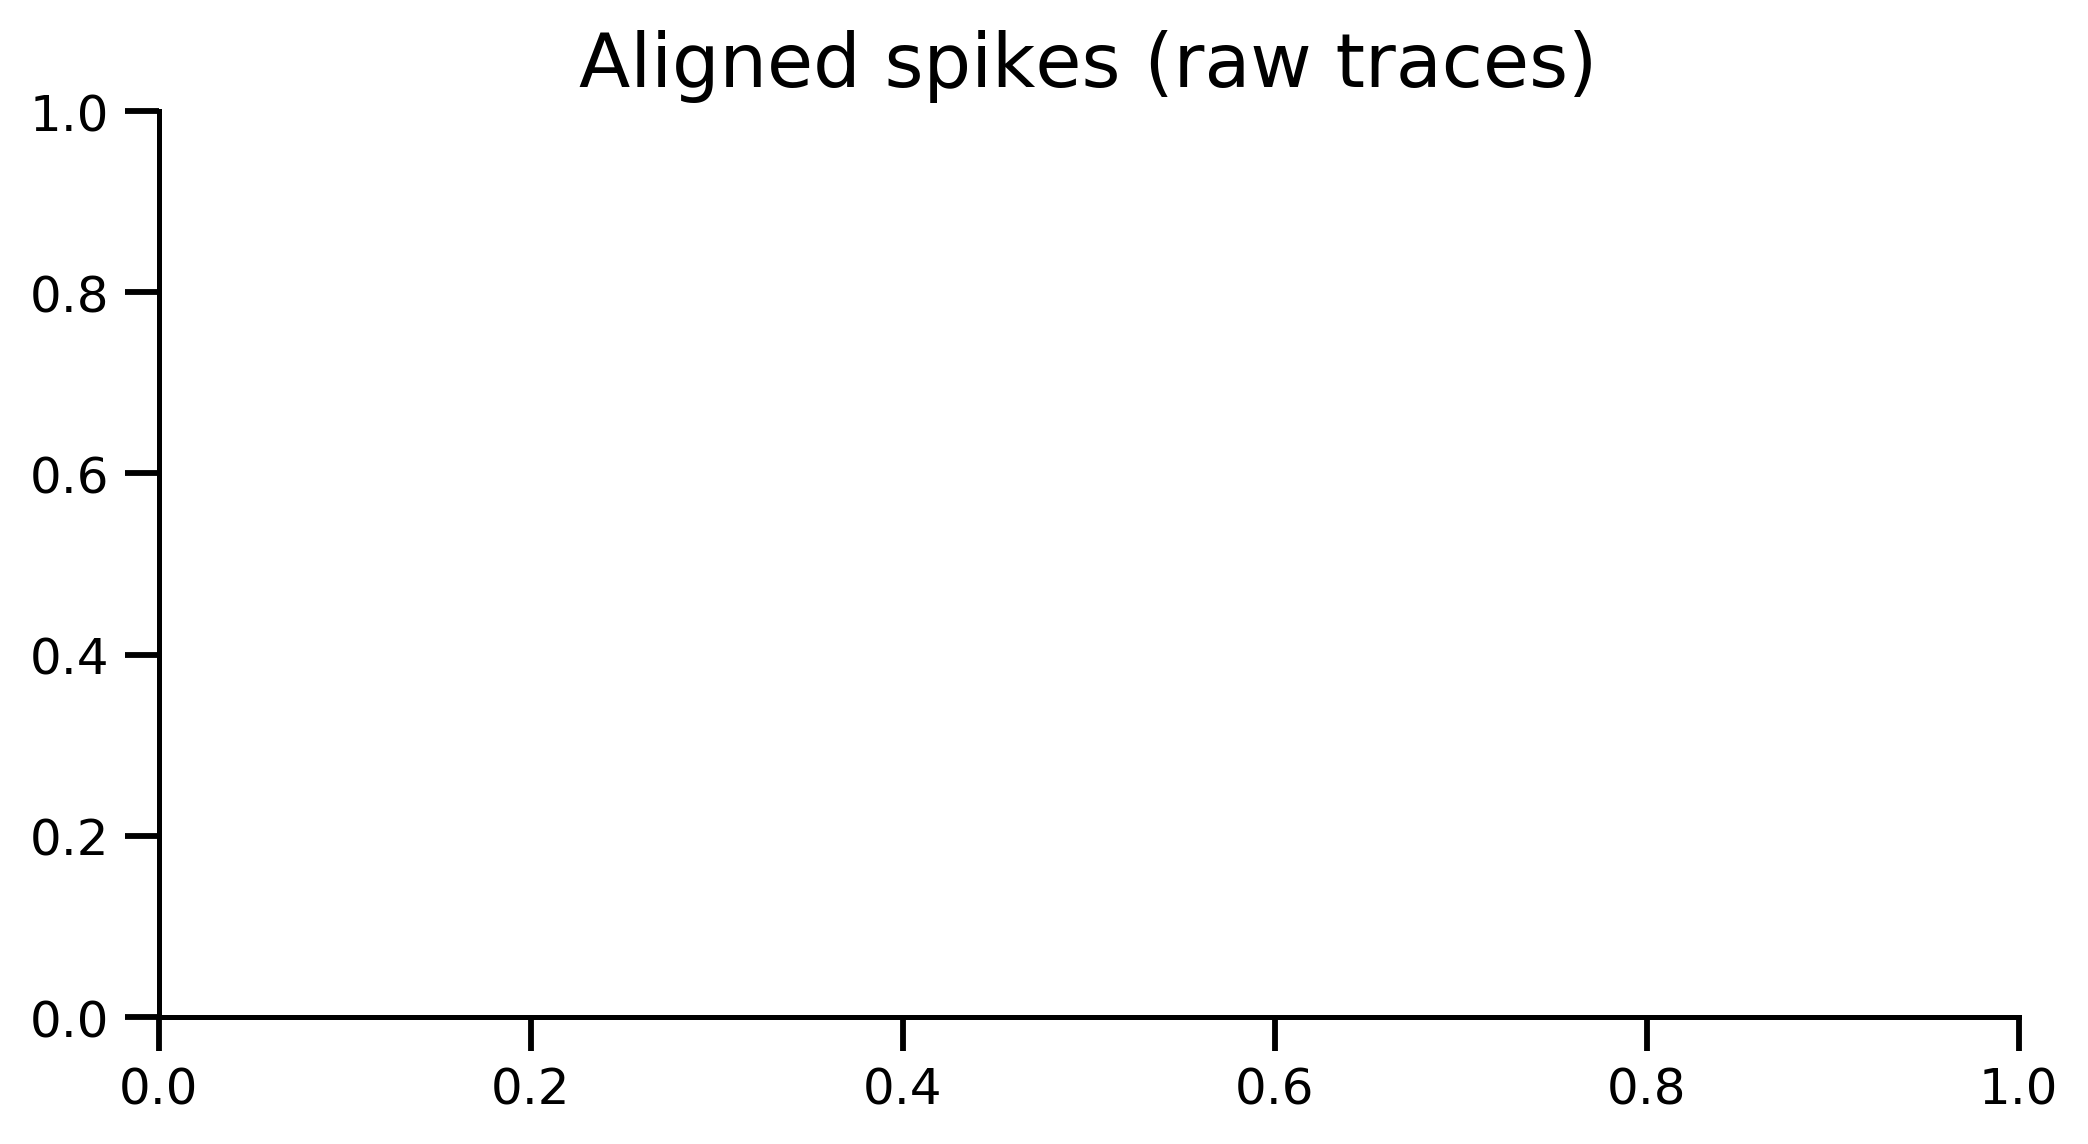

In [6]:
SpikeDataInstance = SpikeData()
doc = pn.Column(pn.Row(pn.Param(SpikeDataInstance.param.load_file_path, 
    widgets={'load_file_path': pn.widgets.FileSelector()})), 
'## Spike Detection', SpikeDataInstance.spike_detection_progress, SpikeDataInstance.spike_alignment_progress,
pn.Row(SpikeDataInstance.param.spike_detection_method, 
       SpikeDataInstance.param.spike_detection_multiplier,
       SpikeDataInstance.param.spike_matrix_cmap, 
       SpikeDataInstance.param.spike_matrix_colorscale),
pn.Row(SpikeDataInstance.param.spike_save_format, SpikeDataInstance.param.save_spikes_button),
pn.Row(SpikeDataInstance.plot_raster, SpikeDataInstance.plot_aligned_spikes),
'## Grid view', pn.Row(SpikeDataInstance.plot_channel_trace, SpikeDataInstance.plot_grid_matrix),
'## Correlation', 
 pn.Row(SpikeDataInstance.param.histogram_metric_to_plot,
        SpikeDataInstance.param.correlation_histogram_num_bin,
       SpikeDataInstance.param.network_edge_correlation_threshold),
                pn.Row(SpikeDataInstance.plot_correlation_matrix, 
                         SpikeDataInstance.plot_network_metric_dist),
'## Network', 
 pn.Row(SpikeDataInstance.param.node_metric_to_plot, 
       SpikeDataInstance.param.node_metric_histogram_num_bin),
 pn.Row(SpikeDataInstance.plot_node_metric_dist,
         SpikeDataInstance.plot_correlation_network)
               )

In [7]:
doc.show()

Launching server at http://localhost:41595


/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/ipykernel_launcher.py:146: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


TODO: make bokeh time series plot
TODO: make bokeh time series plot
TODO: make bokeh time series plot
TODO: make bokeh time series plot


In [62]:
file_path =  SpikeDataInstance.load_file_path[0]

In [65]:
type(SpikeDataInstance.load_file_path) is list

True

In [34]:
pn.pane.Bokeh(SpikeDataInstance.plot_channel_trace())

TODO: make bokeh time series plot


ValueError: Bokeh pane does not support objects of type 'DynamicMap'.

In [49]:
pn.panel(SpikeDataInstance.plot_channel_trace())

TODO: make bokeh time series plot


HoloViews(DynamicMap)

In [29]:
fig = pn.pane.HoloViews(SpikeDataInstance.plot_channel_trace())

TODO: make bokeh time series plot


In [69]:
SpikeDataInstance.plot_channel_trace

<bound method SpikeData.plot_channel_trace of SpikeData(alignment_range=array([0.05, 0.05]), channel_to_plot=1, channle_trace_plotting_backend='matplotlib', correlation_histogram_num_bin=10, fs=25000.0, histogram_metric_to_plot=['correlation'], load_file_path=['/home/timsit/mecp2/python/notebooks/PAT200219_2C_DIV170001.mat'], name='SpikeData05534', network_edge_correlation_threshold=0.5, network_plotting_backend='bokeh', node_metric_histogram_num_bin=10, node_metric_to_plot=['node_degree'], num_channels=60, raw_traces=array([[-4001.3391, -4001.9496, -4002.1938, ..., -4013.3049, -4012.6944,
        -4010.8629],
       [-4003.0485, -4004.1474, -4003.5369, ..., -4007.322 , -4005.1242,
        -4002.5601],
       [-4004.88  , -4003.7811, -4003.2927, ..., -4009.0314, -4009.2756,
        -4009.2756],
       ...,
       [-4008.543 , -4006.8336, -4006.2231, ..., -4011.8397, -4012.206 ,
        -4011.4734],
       [-3999.8739, -3998.2866, -3995.8446, ..., -4003.7811, -4005.3684,
        -4005.0

In [63]:
pn.panel(SpikeDataInstance.plot_channel_trace())

TODO: make bokeh time series plot


HoloViews(DynamicMap)

In [45]:
a = SpikeDataInstance.plot_channel_trace()

TODO: make bokeh time series plot


In [68]:
SpikeDataInstance.raw_trace_df

0          1          2          3          4          5  \
0       -4001.3391 -4003.0485 -4004.8800 -4003.5369 -4000.4844 -4004.3916   
1       -4001.9496 -4004.1474 -4003.7811 -4001.7054 -4000.3623 -4003.7811   
2       -4002.1938 -4003.5369 -4003.2927 -4000.9728 -4001.8275 -4000.9728   
3       -4003.5369 -4003.2927 -4004.0253 -4001.2170 -4003.5369 -3999.2634   
4       -4005.1242 -4003.9032 -4005.0021 -4000.2402 -4004.5137 -4000.8507   
...            ...        ...        ...        ...        ...        ...   
3002495 -4013.9154 -4007.1999 -4008.4209 -4009.6419 -4010.1303 -4015.1364   
3002496 -4014.2817 -4008.6651 -4009.2756 -4009.5198 -4009.3977 -4015.9911   
3002497 -4013.3049 -4007.3220 -4009.0314 -4009.0314 -4007.4441 -4016.2353   
3002498 -4012.6944 -4005.1242 -4009.2756 -4008.4209 -4006.1010 -4015.2585   
3002499 -4010.8629 -4002.5601 -4009.2756 -4008.4209 -4004.8800 -4013.1828   

                 6          7          8          9  ...         51  \
0       -4003.7811 -4000.9728 -4013.6712 -4006.8336  ... -4001.2170   
1       -4005.7347 -4000.6065 -4010.3745 -4007.3220  ... -4000.3623   
2       -4005.8568 -3998.8971 -4007.4441 -4007.0778  ... -3999.5076   
3       -4003.5369 -3996.3330 -4007.1999 -4007.4441  ... -3999.5076   
4       -4000.1181 -3994.1352 -4008.7872 -4007.6883  ... -3999.9960   
...            ...        ...        ...        ...  ...        ...   
3002495 -4005.2463 -4011.5955 -4008.0546 -4007.5662  ... -4010.8629   
3002496 -4006.1010 -4011.2292 -4003.9032 -4006.7115  ... -4010.2524   
3002497 -4004.0253 -4007.1999 -3998.4087 -4004.7579  ... -4008.4209   
3002498 -4001.3391 -4002.8043 -3996.5772 -4004.1474  ... -4005.8568   
3002499 -4000.6065 -4000.7286 -3997.7982 -4003.7811  ... -4003.1706   

                52         53         54         55         56         57  \
0       -4005.4905 -3999.9960 -3999.5076 -3995.9667 -3993.5247 -4008.5430   
1       -4005.7347 -3999.2634 -4001.5833 -3995.3562 -3992.7921 -4006.8336   
2       -4007.5662 -3997.3098 -4002.0717 -3996.3330 -3991.8153 -4006.2231   
3       -4009.2756 -3995.7225 -4002.1938 -3998.1645 -3990.7164 -4006.2231   
4       -4009.3977 -3995.7225 -4002.8043 -3999.3855 -3990.3501 -4006.5894   
...            ...        ...        ...        ...        ...        ...   
3002495 -4007.5662 -4011.7176 -3999.9960 -4008.1767 -4009.7640 -4010.2524   
3002496 -4005.9789 -4011.2292 -4001.8275 -4008.4209 -4011.8397 -4010.8629   
3002497 -4007.8104 -4009.0314 -4002.8043 -4006.8336 -4013.4270 -4011.8397   
3002498 -4010.2524 -4007.3220 -4001.9496 -4005.7347 -4013.5491 -4012.2060   
3002499 -4010.3745 -4006.4673 -4001.8275 -4006.4673 -4011.3513 -4011.4734   

                58         59       Time  
0       -3999.8739 -4003.2927    0.00000  
1       -3998.2866 -4000.2402    0.00004  
2       -3995.8446 -3998.0424    0.00008  
3       -3994.8678 -3998.6529    0.00012  
4       -3996.6993 -4000.4844    0.00016  
...            ...        ...        ...  
3002495 -4005.0021 -4016.2353  120.09980  
3002496 -4003.2927 -4014.8922  120.09984  
3002497 -4003.7811 -4015.2585  120.09988  
3002498 -4005.3684 -4014.6480  120.09992  
3002499 -4005.0021 -4013.0607  120.09996  

[3002500 rows x 61 columns]

In [70]:
type(SpikeDataInstance.plot_correlation_network())

bokeh.models.plots.Plot

Bokeh(Plot)

In [11]:
import holoviews.plotting.mpl
renderer = hv.plotting.mpl.MPLRenderer.instance(dpi=120)
a = SpikeDataInstance.plot_channel_trace
plot = renderer.get_plot(a)

AttributeError: 'function' object has no attribute 'traverse'

In [15]:
dsamp_matrix = SpikeDataInstance.down_sampled_spike_matrix

In [16]:
spike_per_channel = np.sum(dsamp_matrix, axis=1)

In [17]:
spike_per_channel

array([  5,   3,   4,   0, 772,   0,   2, 427,   3,   0,   2,   2,  15,
         1,   0,  57,  11, 251,   0,   2,  19,   5,   1,   3, 860,   1,
         4,   4,   2,  11,   1,   3,  30,   0,   4,   1,  11,   1,   0,
         1,   0,   3,   4,   2,   0,   4,   2,   1,   2,   1,   1,   2,
         0,   2,   3,   2,   2,   2,  25, 565])

In [13]:
%autoreload
a = pspikes.spike_matrix_to_df()

AttributeError: module 'process_spikes' has no attribute 'spike_matrix_to_df'

In [ ]:
pickle_matrix = dsamp_matrix.copy()

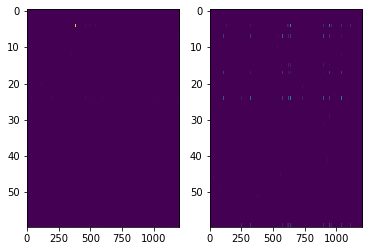

In [18]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pickle_matrix, aspect='auto')
ax[1].imshow(dsamp_matrix, aspect='auto')

In [109]:
SpikeDataInstance.spike_matrix

In [50]:
spike_ds = xr.open_dataset('/home/timsit/mecp2/python/notebooks/PAT200219_2C_DIV17_spikes.nc')

In [54]:


# spike_ds = xr.open_dataset(file_path)
spike_matrix = spike_ds.Spikes.values
num_channels = len(spike_ds['Channel'])
fs = 25000
num_frames = len(spike_ds['Time'])
channel_id = spike_ds['Channel'].values

In [68]:
'.nc' in file_path

True

/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/ipykernel_launcher.py:74: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/timsit/.conda/envs/mecp2/li

In [79]:
file_path = SpikeDataInstance.load_file_path

In [82]:
len(file_path)

2

In [81]:
np.all(['spike' in file_name for file_name in file_path])

True

In [47]:
spike_alignment_traces = list()
num_frame_before_spike = SpikeDataInstance.alignment_range[0] * SpikeDataInstance.fs
num_frame_after_spike = SpikeDataInstance.alignment_range[1] * SpikeDataInstance.fs
for spike_idx in spike_times:
    spike_alignment_traces.append(channel_trace[int(spike_idx - num_frame_before_spike):
                                             int(spike_idx + num_frame_after_spike)])


In [51]:
SpikeDataInstance.alignment_range[0]

-0.3

In [37]:
SpikeDataInstance.spike_matrix = np.stack(spike_train_list)

False

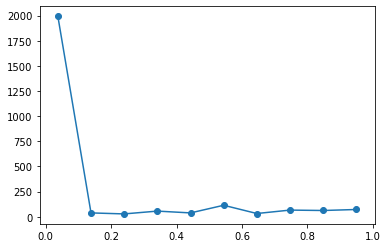

In [52]:
fig, ax = plt.subplots()
metric_name = 'correlation'
corr_vals = SpikeDataInstance.electrode_correlation_matrix.flatten()
corr_vals_remove_nan = corr_vals[~np.isnan(corr_vals)]
frequency, binEdges = np.histogram(corr_vals_remove_nan, 
        bins=SpikeDataInstance.correlation_histogram_num_bin)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
ax.scatter(bincenters, frequency)
ax.plot(bincenters, frequency, label=metric_name)

In [22]:
spike_df_dict = pd.read_pickle('PAT200219_2C_DIV17_spikes.pkl')

In [23]:
spike_df = spike_df_dict['df']

In [24]:
spike_df

spikeTime  electrode
0     106.72100       47.0
1     106.72104       47.0
2     111.91468       47.0
3     111.91472       47.0
4     111.91476       47.0
...         ...        ...
3137  116.75892       57.0
3138  116.75896       57.0
3139  116.75900       57.0
3140  117.85876       57.0
3141  117.85880       57.0

[3142 rows x 2 columns]

In [25]:
np.sum(SpikeDataInstance.spike_matrix)

3142

In [26]:
SpikeDataInstance.recording_duration

120.1

In [59]:
%autoreload
df_converted_matrix, _ = pspikes.bin_spikes_sparse(spike_df, spike_time_column='spikeTime',
                      original_sampling_rate=25000, down_sample_factor=2500,
                      t_start=0, t_end=SpikeDataInstance.recording_duration,
                      cluster_column='electrode', sampling_rate=2000, output_type='dense',
                      cluster_idx=None, cluster_idx_to_row=None)

100%|██████████| 50/50 [00:00<00:00, 2200.76it/s]


In [60]:
np.sum(df_converted_matrix)

3142

In [54]:
t_start = 0
t_end = t_end=SpikeDataInstance.recording_duration
original_sampling_rate = 25000
down_sample_factor = 2500 

num_bins = int(original_sampling_rate / down_sample_factor * (t_end - t_start))
cell_spike_df = spike_df.loc[spike_df['electrode'] == 47]
binned_vector, time_coords = np.histogram(cell_spike_df['spikeTime'], bins=num_bins, range=(t_start, t_end))

In [55]:
np.sum(binned_vector)

5

In [56]:
cell_spike_df

spikeTime  electrode
0  106.72100       47.0
1  106.72104       47.0
2  111.91468       47.0
3  111.91472       47.0
4  111.91476       47.0

In [58]:
t_end

120.1